In [84]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data_path = Path('data', 'store-sales')
data_prepared_path = Path('data', 'store-sales', 'prepared')
holidays = pd.read_csv(
    data_path / 'holidays_events.csv',
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)


# test = pd.read_csv(data_path / 'test.csv')

# Holiday analysis

In [66]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [67]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    category      
 2   locale       350 non-null    category      
 3   locale_name  350 non-null    category      
 4   description  350 non-null    category      
 5   transferred  350 non-null    bool          
dtypes: bool(1), category(4), datetime64[ns](1)
memory usage: 10.5 KB


In [68]:
holidays.describe(include='all').drop('top')

,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,NaN,6,3,24,103,2
freq,NaN,221,174,174,10,338
mean,2015-04-24 00:45:15.428571392,NaN,NaN,NaN,NaN,NaN
min,2012-03-02 00:00:00,NaN,NaN,NaN,NaN,NaN
25%,2013-12-23 06:00:00,NaN,NaN,NaN,NaN,NaN
50%,2015-06-08 00:00:00,NaN,NaN,NaN,NaN,NaN
75%,2016-07-03 00:00:00,NaN,NaN,NaN,NaN,NaN
max,2017-12-26 00:00:00,NaN,NaN,NaN,NaN,NaN


In [69]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [70]:
holidays[holidays['transferred'] == True]

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


In [71]:
holidays[holidays['type'] == 'Transfer']

,date,type,locale,locale_name,description,transferred
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False
269,2016-08-12,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
298,2017-01-02,Transfer,National,Ecuador,Traslado Primer dia del ano,False
304,2017-04-13,Transfer,Local,Cuenca,Fundacion de Cuenca,False
313,2017-05-26,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False


### Since some of the holidays were transfered to other day, I want to keep only the records with holidays that were celebrated at this time. The celebration date of the holiday affect the store sale, not the calendar holiday day.

```Python
holidays['transferred'] == False
```
Will give the result only with celebration dates (both transfered and not)

In [72]:
holidays = holidays[holidays['transferred'] == False]

In [73]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [74]:
holidays['description'] = holidays['description'].str.replace('Traslado ', '')
holidays.drop('transferred', axis=1, inplace=True)  # No longer needed

In [75]:
holidays.to_csv(data_prepared_path / 'holidays.csv', index=False)

# Oil analysis

Since Ecuador is oil-dependent country, oil prices may be useful in our store sales predictions

In [81]:
oil = pd.read_csv(
    data_path / 'oil.csv',
    parse_dates=['date']
)
oil.set_index('date', inplace=True)

In [83]:
oil.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


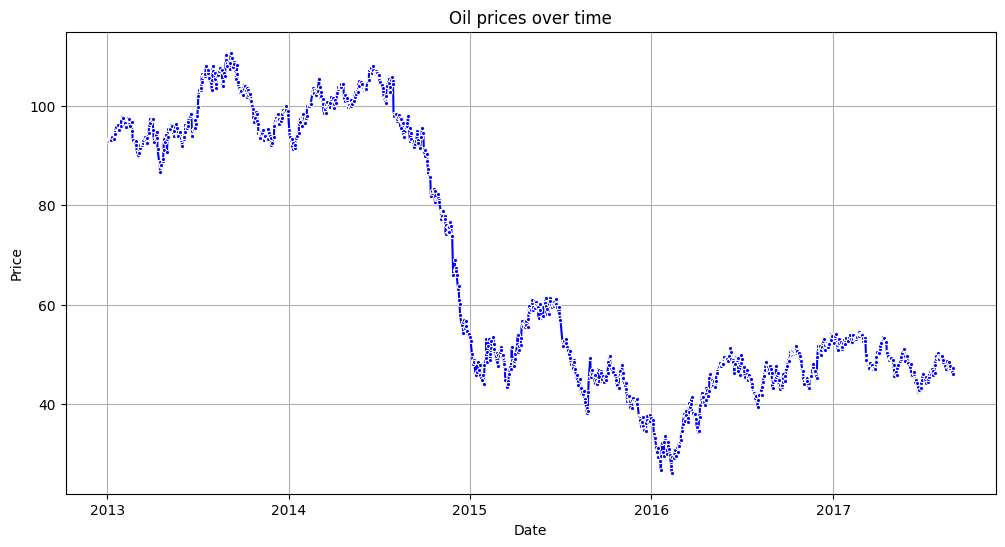

In [86]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=oil, x=oil.index, y='dcoilwtico', marker='.', color='b')
plt.xlabel('Date')
plt.ylabel('Price'),
plt.title('Oil prices over time')
plt.grid()

# Stores analysis

In [141]:
stores = pd.read_csv(
    data_path / 'stores.csv',
    dtype={
        'city': 'category',
        'state': 'category',
        'type': 'category'
    }
)

In [142]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


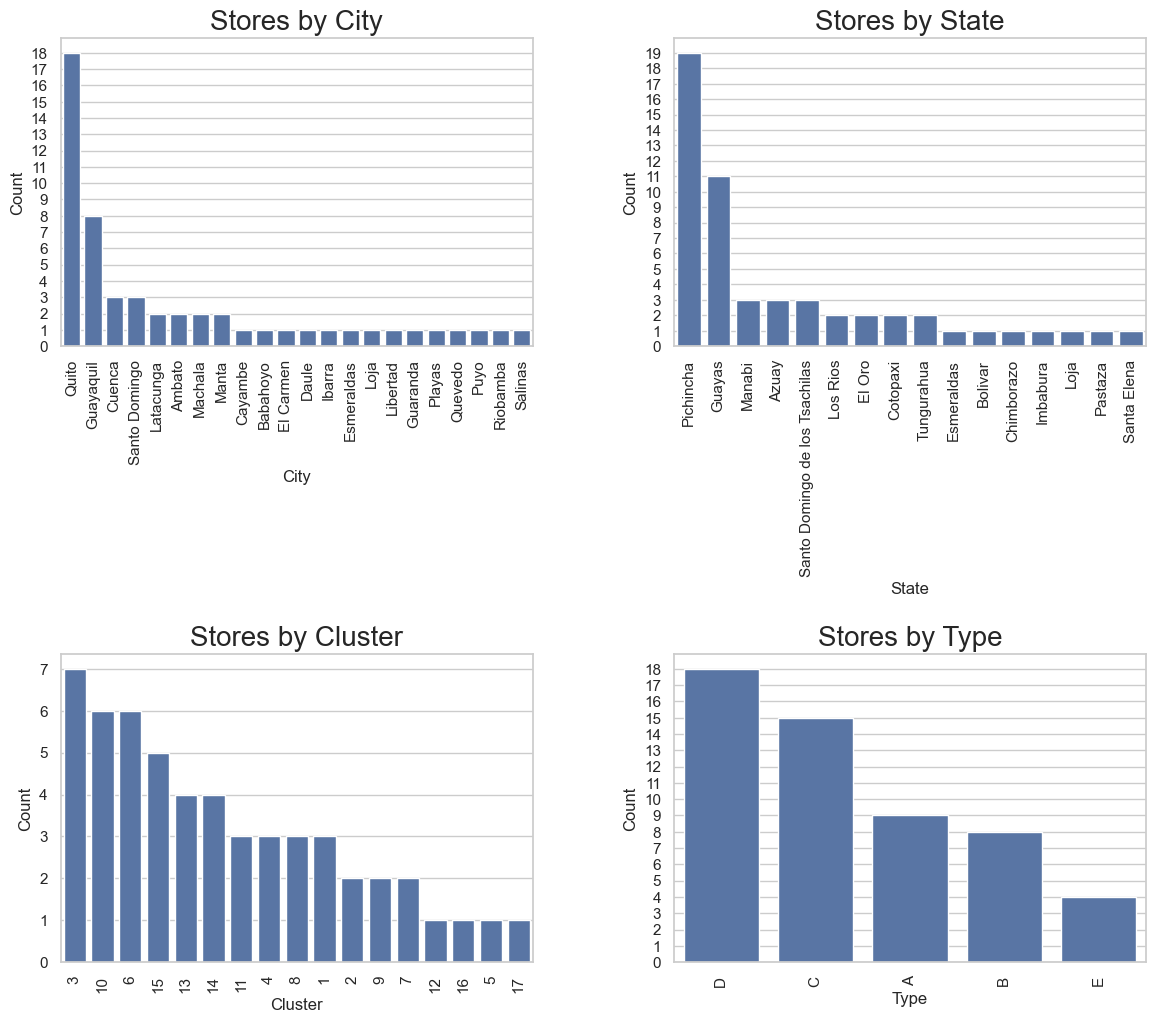

In [143]:
def plot_store_counts(df, columns):
    """
    Plots bar charts for the count of stores based on given categorical columns in a 2x2 subplot layout.

    Parameters:
    df (pd.DataFrame): The dataframe containing store data.
    columns (list): List of column names to plot (max 4 for 2x2 layout).
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()

    for i, col in enumerate(columns[:4]):
        sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=axes[i])
        axes[i].set_title(f"Stores by {col.capitalize()}", fontsize=20)
        axes[i].set_xlabel(col.capitalize())
        axes[i].set_ylabel("Count")
        axes[i].tick_params(axis='x', rotation=90)
        
        # Changing y axis show integer values only
        max_count = df[col].value_counts().max()
        axes[i].set_yticks(np.arange(0, max_count + 1, step=1))

    # Hide unused subplots if columns < 4
    for j in range(len(columns), 4):
        fig.delaxes(axes[j])

    # Prevent lab
    plt.subplots_adjust(hspace=1, wspace=0.3)  
    plt.show()

# fig, axes = plt.subplots(2, 2, figsize=(16, 12))
# axes = axes.flatten()
plot_store_counts(stores, ["city", "state", "cluster", "type"])  # Pass up to 4 columns

# Train data analysis

In [ ]:
# train = pd.read_csv(data_path / 'train.csv')


# Training the models